In [ ]:
# !pip install yfinance
# !pip install TA-Lib 
# !pip install numpy
# !pip install pandas
# !pip install vectorbt
# !pip install scipy

In [ ]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import vectorbt as vbt
import warnings
from scipy import stats
import matplotlib.pyplot as plt


In [ ]:
# DOWNLOAD STOCK DATA FROM 2018 USING YFINANCE

# Configuration - Change these variables as needed
TICKER = 'BTC-USD'  # Any ticker symbol (e.g., 'AAPL', 'MSFT', 'GOOGL')
START_DATE = '2018-01-01'  # Any start date in YYYY-MM-DD format

# Download data from start date onwards
stock_data = yf.download(TICKER, start=START_DATE, interval='1d')

if not stock_data.empty:
    print(f"Successfully downloaded {len(stock_data)} records for {TICKER} from {START_DATE}")
    print(f"Data range: {stock_data.index.min().date()} to {stock_data.index.max().date()}")
    print("\nFirst 5 rows:")
    print(stock_data.head())
else:
    print(f"Failed to download {TICKER} data from yfinance")

# Display the downloaded data
stock_data


C:\Users\koko\AppData\Local\Temp\ipykernel_8340\896142296.py:8: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Successfully downloaded 2874 records for BTC-USD from 2018-01-01
Data range: 2018-01-01 to 2025-11-14

First 5 rows:
Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2018-01-01  13657.200195  14112.200195  13154.700195  14112.200195   
2018-01-02  14982.099609  15444.599609  13163.599609  13625.000000   
2018-01-03  15201.000000  15572.799805  14844.500000  14978.200195   
2018-01-04  15599.200195  15739.700195  14522.200195  15270.700195   
2018-01-05  17429.500000  17705.199219  15202.799805  15477.200195   

Price            Volume  
Ticker          BTC-USD  
Date                     
2018-01-01  10291200000  
2018-01-02  16846600192  
2018-01-03  16871900160  
2018-01-04  21783199744  
2018-01-05  23840899072  


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072
...,...,...,...,...,...
2025-11-09,104719.640625,105418.367188,101468.875000,102278.984375,59679243013
2025-11-10,105996.593750,106564.695312,104350.648438,104723.773438,69585887229


In [ ]:
# TECHNICAL ANALYSIS INDICATORS USING TA-LIB

# Make sure stock_data is available from the previous cell
if "stock_data" not in locals():
    raise ValueError("Please run the stock data download cell first")

# Extract OHLCV data (handling multi-level columns from yfinance)
if isinstance(stock_data.columns, pd.MultiIndex):
    close = stock_data[("Close", TICKER)].values
    high = stock_data[("High", TICKER)].values
    low = stock_data[("Low", TICKER)].values
    open_ = stock_data[("Open", TICKER)].values
    volume = stock_data[("Volume", TICKER)].values
else:
    close = stock_data["Close"].values
    high = stock_data["High"].values
    low = stock_data["Low"].values
    open_ = stock_data["Open"].values
    volume = stock_data["Volume"].values

print(f"Calculating technical indicators for {TICKER}...")

# Simple Moving Averages
sma_20 = talib.SMA(close, timeperiod=20)
sma_50 = talib.SMA(close, timeperiod=50)

# Exponential Moving Averages
ema_12 = talib.EMA(close, timeperiod=12)
ema_26 = talib.EMA(close, timeperiod=26)

# MACD
macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

# RSI
rsi = talib.RSI(close, timeperiod=14)

# Stochastic RSI
stochrsi_k, stochrsi_d = talib.STOCHRSI(close, timeperiod=14, fastk_period=3, fastd_period=3, fastd_matype=0)

# VWAP (manual calculation)
typical_price = (high + low + close) / 3
price_volume = typical_price * volume
cumulative_price_volume = np.cumsum(price_volume)
cumulative_volume = np.cumsum(volume)
vwap = cumulative_price_volume / cumulative_volume

# Schaff Trend Cycle
cycle_period = 10
macd_cycle = talib.EMA(macd, timeperiod=cycle_period)
macd_smooth = talib.EMA(macd_cycle, timeperiod=cycle_period)
highest_macd = talib.MAX(macd_smooth, timeperiod=cycle_period)
lowest_macd = talib.MIN(macd_smooth, timeperiod=cycle_period)
stc_k = 100 * ((macd_smooth - lowest_macd) / (highest_macd - lowest_macd))
stc_d = talib.SMA(stc_k, timeperiod=3)

# Create indicators dataframe
indicators_df = pd.DataFrame({
    "Date": stock_data.index,
    "Close": close,
    "SMA_20": sma_20,
    "SMA_50": sma_50,
    "EMA_12": ema_12,
    "EMA_26": ema_26,
    "MACD": macd,
    "MACD_Signal": macdsignal,
    "MACD_Hist": macdhist,
    "RSI": rsi,
    "StochRSI_K": stochrsi_k,
    "StochRSI_D": stochrsi_d,
    "VWAP": vwap,
    "STC_K": stc_k,
    "STC_D": stc_d
})

print("All technical indicators calculated!")
print(f"Data shape: {indicators_df.shape}")
indicators_df.tail(5)

Calculating technical indicators for BTC-USD...
All technical indicators calculated!
Data shape: (2874, 15)


,Date,Close,SMA_20,SMA_50,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist,RSI,StochRSI_K,StochRSI_D,VWAP,STC_K,STC_D
2869,2025-11-09,104719.640625,108139.239062,112069.566719,105635.215139,108252.387397,-2617.172258,-2140.422522,-476.749736,43.004247,100.0,8.915685e+01,49451.133432,0.0,4.736952e-15
2870,2025-11-10,105996.593750,108015.224219,111883.376719,105690.811849,108085.291571,-2394.479723,-2191.233962,-203.245761,45.650441,100.0,8.915685e+01,49496.948446,0.0,4.736952e-15
2871,2025-11-11,102997.468750,107780.668359,111688.355938,105276.451372,107708.415807,-2431.964435,-2239.380057,-192.584378,40.853022,0.0,6.666667e+01,49542.584553,0.0,4.736952e-15
2872,2025-11-12,101663.187500,107360.341406,111481.329687,104720.564622,107260.621118,-2540.056495,-2299.515344,-240.541151,38.894673,0.0,3.333333e+01,49582.527101,0.0,4.736952e-15
2873,2025-11-14,95730.164062,106595.153516,111129.360312,103337.426075,106406.513188,-3069.087113,-2453.429698,-615.657415,31.633230,0.0,-1.705303e-13,49648.366898,0.0,4.736952e-15


In [ ]:
# PREPARE PRICE SERIES

warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)

# Expect stock_data and TICKER already exist
def select_close_series(df, ticker):
    if isinstance(df.columns, pd.MultiIndex):
        if ('Close', ticker) in df.columns:
            s = df[('Close', ticker)]
        else:
            cols = [c for c in df.columns if 'Close' in str(c)]
            if not cols:
                raise KeyError("Close not found")
            s = df[cols[0]]
    else:
        s = df['Close']
    return s.astype(float).squeeze()

close = select_close_series(stock_data, TICKER)
close.name = 'price'

# Simple split
TRAIN_RATIO = 0.60 
split_idx = int(len(close) * TRAIN_RATIO)
train_close = close.iloc[:split_idx].copy()
val_close   = close.iloc[split_idx:].copy()

print(f"Data ready: train={train_close.index[0].date()} → {train_close.index[-1].date()} | val={val_close.index[0].date()} → {val_close.index[-1].date()}")

Data ready: train=2018-01-01 → 2022-09-20 | val=2022-09-21 → 2025-11-14


TRIPLE EMA CROSSOVER GRID SEARCH - TRAINING SET
----------------------------------------------

This section performs a comprehensive grid search optimization for the **Triple EMA Crossover Strategy** using only the **training data**.

The goal is to find the optimal EMA1/EMA2/EMA3 combination that maximizes the Sharpe ratio on unseen data.

**Strategy Logic**: Buy when any EMA crosses above another (EMA1 > EMA2, EMA1 > EMA3, or EMA2 > EMA3). Sell when any EMA crosses below another.

---

In [ ]:
# Define Parameter Ranges for Triple EMA Crossover

# EMA periods for triple crossover strategy
ema1_periods = list(range(4, 40, 5))    # Fast EMA (shortest-term)
ema2_periods = list(range(50, 90, 5))  # Medium EMA (medium-term)
ema3_periods = list(range(120, 250, 5)) # Slow EMA (longest-term)



print("EMA1 Periods (fast - shortest-term):")
for i, period in enumerate(ema1_periods, 1):
    print(f"  {i}. {period} periods")

print("EMA2 Periods (medium - medium-term):")
for i, period in enumerate(ema2_periods, 1):
    print(f"  {i}. {period} periods")

print("EMA3 Periods (slow - longest-term):")
for i, period in enumerate(ema3_periods, 1):
    print(f"  {i}. {period} periods")

# Generate all valid combinations (ema1 < ema2 < ema3)
ema_combinations = []
for ema1 in ema1_periods:
    for ema2 in ema2_periods:
        for ema3 in ema3_periods:
            if ema1 < ema2 < ema3:
                ema_combinations.append((ema1, ema2, ema3))

print(f"Generated {len(ema_combinations)} valid Triple EMA combinations")
print("\n📋 First 10 combinations preview:")
for i, (ema1, ema2, ema3) in enumerate(ema_combinations[:10], 1):
    print(f"  {i:2d}. EMA1: {ema1:2d} | EMA2: {ema2:2d} | EMA3: {ema3:2d}")
if len(ema_combinations) > 10:
    print(f"   ... and {len(ema_combinations) - 10} more combinations")

print("Ready to test all combinations on training data!")

EMA1 Periods (fast - shortest-term):
  1. 4 periods
  2. 9 periods
  3. 14 periods
  4. 19 periods
  5. 24 periods
  6. 29 periods
  7. 34 periods
  8. 39 periods
EMA2 Periods (medium - medium-term):
  1. 50 periods
  2. 55 periods
  3. 60 periods
  4. 65 periods
  5. 70 periods
  6. 75 periods
  7. 80 periods
  8. 85 periods
EMA3 Periods (slow - longest-term):
  1. 120 periods
  2. 125 periods
  3. 130 periods
  4. 135 periods
  5. 140 periods
  6. 145 periods
  7. 150 periods
  8. 155 periods
  9. 160 periods
  10. 165 periods
  11. 170 periods
  12. 175 periods
  13. 180 periods
  14. 185 periods
  15. 190 periods
  16. 195 periods
  17. 200 periods
  18. 205 periods
  19. 210 periods
  20. 215 periods
  21. 220 periods
  22. 225 periods
  23. 230 periods
  24. 235 periods
  25. 240 periods
  26. 245 periods
Generated 1664 valid Triple EMA combinations

📋 First 10 combinations preview:
   1. EMA1:  4 | EMA2: 50 | EMA3: 120
   2. EMA1:  4 | EMA2: 50 | EMA3: 125
   3. EMA1:  4 | EMA2:

In [ ]:
# Initialize Triple EMA Results Collection System

# Create empty list to store all backtest results
grid_search_results = []

print("Triple EMA Results Collection System Initialized")
print(f"   - Will test {len(ema_combinations)} Triple EMA combinations")
print("   - Results will be stored in 'grid_search_results' list")

# Define what metrics we will collect (All TradingView-style metrics)
metrics_to_collect = [
    # Strategy Parameters
    "ema1_period",
    "ema2_period", 
    "ema3_period",
    
    # Return Metrics
    "total_return",
    "annualized_return",
    "total_profit",
    
    # Risk-Adjusted Return Metrics
    "sharpe_ratio",
    "sortino_ratio",
    "calmar_ratio",
    "omega_ratio",
    "information_ratio",
    "tail_ratio",
    "deflated_sharpe_ratio",
    
    # Risk Metrics
    "max_drawdown",
    "volatility",
    "ulcer_index",
    
    # Trade Performance Metrics
    "win_rate",
    "total_trades",
    "avg_trade_duration",
    "expectancy",
    "profit_factor", 
    "sqn",
    
    # Win/Loss Analysis
    "payoff_ratio",
    "largest_win",
    "largest_loss",
    "avg_win_amount",
    "avg_loss_amount",
    "winning_streak",
    "losing_streak",
    
    # Additional Ratios
    "recovery_factor",
    "gain_to_pain_ratio",
    "serenity_index"
]

print("Metrics to collect for each Triple EMA combination:")
for i, metric in enumerate(metrics_to_collect, 1):
    print(f"  {i}. {metric.replace('_', ' ').title()}")

print("Ready to start the Triple EMA grid search!")


Triple EMA Results Collection System Initialized
   - Will test 1664 Triple EMA combinations
   - Results will be stored in 'grid_search_results' list
Metrics to collect for each Triple EMA combination:
  1. Ema1 Period
  2. Ema2 Period
  3. Ema3 Period
  4. Total Return
  5. Annualized Return
  6. Total Profit
  7. Sharpe Ratio
  8. Sortino Ratio
  9. Calmar Ratio
  10. Omega Ratio
  11. Information Ratio
  12. Tail Ratio
  13. Deflated Sharpe Ratio
  14. Max Drawdown
  15. Volatility
  16. Ulcer Index
  17. Win Rate
  18. Total Trades
  19. Avg Trade Duration
  20. Expectancy
  21. Profit Factor
  22. Sqn
  23. Payoff Ratio
  24. Largest Win
  25. Largest Loss
  26. Avg Win Amount
  27. Avg Loss Amount
  28. Winning Streak
  29. Losing Streak
  30. Recovery Factor
  31. Gain To Pain Ratio
  32. Serenity Index
Ready to start the Triple EMA grid search!


In [ ]:
# VISUALIZE SIGNALS FOR ONE EXAMPLE

example_ema1, example_ema2, example_ema3 = 7, 93, 152
ema1_ma = vbt.MA.run(train_close, example_ema1, ewm=True).ma
ema2_ma = vbt.MA.run(train_close, example_ema2, ewm=True).ma
ema3_ma = vbt.MA.run(train_close, example_ema3, ewm=True).ma

# Triple EMA crossover signals
entries_1 = ema1_ma.vbt.crossed_above(ema2_ma).reindex(train_close.index).fillna(False)
entries_2 = ema1_ma.vbt.crossed_above(ema3_ma).reindex(train_close.index).fillna(False)
entries_3 = ema2_ma.vbt.crossed_above(ema3_ma).reindex(train_close.index).fillna(False)
entries = entries_1 | entries_2 | entries_3

exits_1 = ema1_ma.vbt.crossed_below(ema2_ma).reindex(train_close.index).fillna(False)
exits_2 = ema1_ma.vbt.crossed_below(ema3_ma).reindex(train_close.index).fillna(False)
exits_3 = ema2_ma.vbt.crossed_below(ema3_ma).reindex(train_close.index).fillna(False)
exits = exits_1 | exits_2 | exits_3

signals_df = pd.DataFrame({
    'Close': train_close.values,
    'EMA1': ema1_ma.values,
    'EMA2': ema2_ma.values,
    'EMA3': ema3_ma.values,
    'Buy': entries.values.astype(bool),
    'Sell': exits.values.astype(bool)
}, index=train_close.index)
signals_df.index.name = 'Date'

pos = 0
pos_list = []
for buy, sell in zip(signals_df['Buy'], signals_df['Sell']):
    if buy: pos = 1
    elif sell: pos = 0
    pos_list.append(pos)
signals_df['Position'] = pos_list

print(f"Example EMA({example_ema1},{example_ema2},{example_ema3}) signals:")
print(signals_df.head(500).to_string())


Example EMA(7,93,152) signals:
                   Close          EMA1          EMA2         EMA3    Buy   Sell  Position
Date                                                                                     
2018-01-01  13657.200195           NaN           NaN          NaN  False  False         0
2018-01-02  14982.099609           NaN           NaN          NaN  False  False         0
2018-01-03  15201.000000           NaN           NaN          NaN  False  False         0
2018-01-04  15599.200195           NaN           NaN          NaN  False  False         0
2018-01-05  17429.500000           NaN           NaN          NaN  False  False         0
2018-01-06  17527.000000           NaN           NaN          NaN  False  False         0
2018-01-07  16477.599609  16023.905672           NaN          NaN  False  False         0
2018-01-08  15170.099609  15810.454156           NaN          NaN  False  False         0
2018-01-09  14595.400391  15506.690715           NaN          NaN  Fa

In [ ]:
# TRIPLE EMA CROSSOVER GRID SEARCH ON TRAINING DATA

print("INITIATING TRIPLE EMA CROSSOVER GRID SEARCH OPTIMIZATION")
print("=" * 70)
print(f"Testing Strategy: Triple Exponential Moving Average Crossover")
print(f"Training Period: {train_close.index[0].date()} → {train_close.index[-1].date()}")
print(f"Initial Capital: $100,000")
print(f"Transaction Costs: 0.05% per trade (fees + slippage)")
print(f"Optimization Metric: Sharpe Ratio (risk-adjusted returns)")
print("=" * 70)

# Ensure results container exists
if 'grid_search_results' not in locals():
    grid_search_results = []

# Initialize grid search tracking
total_combinations = len(ema_combinations)
successful_tests = 0
failed_tests = 0

print(f"Starting grid search across {total_combinations} parameter combinations...\n")

for i, (ema1_period, ema2_period, ema3_period) in enumerate(ema_combinations, 1):
    try:
        # INDICATORS
        ema1 = vbt.MA.run(train_close, ema1_period, ewm=True)
        ema2 = vbt.MA.run(train_close, ema2_period, ewm=True)
        ema3 = vbt.MA.run(train_close, ema3_period, ewm=True)

        # SIGNALS (cast to plain Series to avoid vbt ColumnsOnly errors)
        entries_raw = (
            ema1.ma_crossed_above(ema2.ma) |
            ema1.ma_crossed_above(ema3.ma) |
            ema2.ma_crossed_above(ema3.ma)
        )
        exits_raw = (
            ema1.ma_crossed_below(ema2.ma) |
            ema1.ma_crossed_below(ema3.ma) |
            ema2.ma_crossed_below(ema3.ma)
        )
        
        # ⚠️ FIX LOOKAHEAD BIAS: Shift signals by 1 bar (avoiding FutureWarning)
        entries_series = pd.Series(np.asarray(entries_raw).ravel(), index=train_close.index, dtype=bool)
        exits_series = pd.Series(np.asarray(exits_raw).ravel(), index=train_close.index, dtype=bool)
        
        # Shift and fill with explicit boolean conversion
        entries = entries_series.shift(1)
        entries = entries.where(entries.notna(), False).astype(bool)
        
        exits = exits_series.shift(1)
        exits = exits.where(exits.notna(), False).astype(bool)

        # BACKTEST
        portfolio = vbt.Portfolio.from_signals(
            close=train_close,
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.0005,
            slippage=0.0005,
            freq='D'
        )

        # PORTFOLIO METRICS
        total_return = float(portfolio.total_return())
        annualized_return = float(portfolio.annualized_return(freq='D'))
        max_drawdown = float(portfolio.max_drawdown())
        volatility = float(portfolio.annualized_volatility(freq='D'))
        sharpe_ratio = float(portfolio.sharpe_ratio(freq='D'))
        sortino_ratio = float(portfolio.sortino_ratio(freq='D'))
        try:
            information_ratio = float(portfolio.information_ratio(freq='D'))
        except Exception:
            information_ratio = np.nan
        try:
            tail_ratio = float(portfolio.tail_ratio(freq='D'))
        except Exception:
            tail_ratio = np.nan
        try:
            deflated_sharpe_ratio = float(portfolio.deflated_sharpe_ratio(freq='D'))
        except Exception:
            deflated_sharpe_ratio = np.nan

        # Ulcer Index
        returns = portfolio.returns()
        cum = (1 + returns).cumprod()
        peak = cum.cummax()
        dd = (cum - peak) / peak
        ulcer_index = float(np.sqrt((dd.pow(2)).mean())) if len(dd) else np.nan

        # TRADE METRICS 
        trades = portfolio.trades
        total_trades = int(len(trades))
        win_rate_pct = np.nan
        profit_factor = np.nan
        expectancy = 0.0
        avg_win_amount = 0.0
        avg_loss_amount = 0.0

        if total_trades > 0:
            tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
            if tr.size > 0:
                pos = tr[tr > 0]
                neg = tr[tr < 0]
                win_rate_pct = (len(pos) / len(tr)) * 100.0
                gains = pos.sum() if len(pos) else 0.0
                losses = abs(neg.sum()) if len(neg) else 0.0
                profit_factor = (gains / losses) if losses > 0 else np.inf
                expectancy = float(tr.mean())
                avg_win_amount = float(pos.mean()) if len(pos) else 0.0
                avg_loss_amount = float(abs(neg.mean())) if len(neg) else 0.0

        # Trades per year
        years = max((train_close.index[-1] - train_close.index[0]).days / 365.25, 1e-9)
        trades_per_year = total_trades / years

        # Soft skip: ignore parameter combinations with insufficient trading activity
        if trades_per_year < 2:
            continue

        # Payoff ratio and streaks (optional, safe defaults)
        payoff_ratio = (avg_win_amount / avg_loss_amount) if avg_loss_amount not in (0.0, np.nan) else np.inf
        try:
            winning_streak = int(trades.winning_streak())
            losing_streak = int(trades.losing_streak())
        except Exception:
            winning_streak = np.nan
            losing_streak = np.nan

        # RESULTS
        grid_search_results.append({
            "ema1_period": ema1_period,
            "ema2_period": ema2_period,
            "ema3_period": ema3_period,
            "total_return": total_return,
            "annualized_return": annualized_return,
            "max_drawdown": max_drawdown,
            "volatility": volatility,
            "sharpe_ratio": sharpe_ratio,
            "sortino_ratio": sortino_ratio,
            "information_ratio": information_ratio,
            "tail_ratio": tail_ratio,
            "deflated_sharpe_ratio": deflated_sharpe_ratio,
            "ulcer_index": ulcer_index,
            "total_trades": total_trades,
            "win_rate": win_rate_pct,              
            "profit_factor": profit_factor,
            "expectancy": expectancy,
            "avg_win_amount": avg_win_amount,
            "avg_loss_amount": avg_loss_amount,
            "payoff_ratio": payoff_ratio,
            "winning_streak": winning_streak,
            "losing_streak": losing_streak,
            "trades_per_year": trades_per_year
        })
        successful_tests += 1

        # PROGRESS
        if i % 10 == 0 or i == total_combinations:
            progress_pct = (i / total_combinations) * 100
            print(f"Progress: {i}/{total_combinations} ({progress_pct:.1f}%)")
            print(f"   Successful: {successful_tests} |  Failed: {failed_tests}")
            print(f"   Latest: EMA({ema1_period},{ema2_period},{ema3_period}) → Sharpe: {sharpe_ratio:.3f}, Return: {total_return:.1%}")
            print(f"   Trades: {total_trades}, Win Rate: {win_rate_pct:.1f}%, Max DD: {max_drawdown:.1%}\n")

    except Exception as e:
        failed_tests += 1
        if i % 10 == 0 or i == total_combinations:
            print(f"Error with EMA({ema1_period},{ema2_period},{ema3_period}): {str(e)[:80]}...")

# SUMMARY

print("GRID SEARCH COMPLETED!")

print(f"Total combinations attempted: {total_combinations}")
print(f"Successfully completed: {successful_tests}")
print(f"Failed: {failed_tests}")
print(f"Success rate: {(successful_tests/total_combinations)*100:.1f}%")
print("\nResults stored in 'grid_search_results'")

INITIATING TRIPLE EMA CROSSOVER GRID SEARCH OPTIMIZATION
Testing Strategy: Triple Exponential Moving Average Crossover
Training Period: 2018-01-01 → 2022-09-20
Initial Capital: $100,000
Transaction Costs: 0.05% per trade (fees + slippage)
Optimization Metric: Sharpe Ratio (risk-adjusted returns)
Starting grid search across 1664 parameter combinations...

Progress: 10/1664 (0.6%)
   Successful: 10 |  Failed: 0
   Latest: EMA(4,50,165) → Sharpe: 0.985, Return: 441.7%
   Trades: 29, Win Rate: 31.0%, Max DD: -42.9%

Progress: 20/1664 (1.2%)
   Successful: 20 |  Failed: 0
   Latest: EMA(4,50,215) → Sharpe: 1.009, Return: 470.1%
   Trades: 28, Win Rate: 28.6%, Max DD: -47.5%

Progress: 30/1664 (1.8%)
   Successful: 30 |  Failed: 0
   Latest: EMA(4,55,135) → Sharpe: 1.075, Return: 560.9%
   Trades: 28, Win Rate: 35.7%, Max DD: -39.7%

Progress: 40/1664 (2.4%)
   Successful: 40 |  Failed: 0
   Latest: EMA(4,55,185) → Sharpe: 1.050, Return: 523.6%
   Trades: 27, Win Rate: 33.3%, Max DD: -45.4%


In [ ]:
# Analyze Triple EMA Grid Search Results

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search_results)

print("Grid Search Results Analysis")
print("=" * 50)
print(f"Total combinations tested: {len(results_df)}")
print(f"Results shape: {results_df.shape}")

# Comprehensive TradingView-style statistics
print("Comprehensive Performance Statistics:")
print("-" * 50)

# Return Metrics
print("Return Metrics:")
print(f"   Best Total Return: {results_df['total_return'].max():.2%}")
print(f"   Average Total Return: {results_df['total_return'].mean():.2%}")
print(f"   Best Annualized Return: {results_df['annualized_return'].max():.2%}")

# Risk-Adjusted Metrics
print("Risk-Adjusted Return Metrics:")
print(f"   Best Sharpe Ratio: {results_df['sharpe_ratio'].max():.3f}")
print(f"   Best Sortino Ratio: {results_df['sortino_ratio'].max():.3f}")

# Risk Metrics
print("Risk Metrics:")
print(f"   Average Max Drawdown: {results_df['max_drawdown'].mean():.2%}")
print(f"   Best Max Drawdown: {results_df['max_drawdown'].min():.2%}")
print(f"   Average Volatility: {results_df['volatility'].mean():.2%}")

# Trade Performance
print("Trade Performance:")
print(f"   Best Win Rate: {results_df['win_rate'].max():.1f}%")  # Changed from :.1%
print(f"   Average Win Rate: {results_df['win_rate'].mean():.1f}%")  # Changed from :.1%
print(f"   Best Profit Factor: {results_df['profit_factor'].max():.2f}")
print(f"   Total Trades Range: {results_df['total_trades'].min():.0f} - {results_df['total_trades'].max():.0f}")

# Additional Available Metrics
print("Additional Metrics:")
print(f"   Best Expectancy: {results_df['expectancy'].max():.4f}")
print(f"   Average Trades per Year: {results_df['trades_per_year'].mean():.1f}")

# Find best combination by Sharpe ratio
best_result = results_df.loc[results_df['sharpe_ratio'].idxmax()]

print("BEST STRATEGY (by Sharpe Ratio)")
print("-" * 50)
print(f"EMA1 Period (Fast): {int(best_result['ema1_period'])}")
print(f"EMA2 Period (Medium): {int(best_result['ema2_period'])}")
print(f"EMA3 Period (Slow): {int(best_result['ema3_period'])}")
print(f"Total Return: {best_result['total_return']:.2%}")
print(f"Sharpe Ratio: {best_result['sharpe_ratio']:.3f}")
print(f"Max Drawdown: {best_result['max_drawdown']:.2%}")
print(f"Win Rate: {best_result['win_rate']:.1f}%")  # Changed from :.1%
print(f"Total Trades: {int(best_result['total_trades'])}")

print("Top 5 Best Performers:")
top_5 = results_df.nlargest(5, "sharpe_ratio")
for i, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"{i}. EMA({int(row['ema1_period'])},{int(row['ema2_period'])},{int(row['ema3_period'])}) → Sharpe: {row['sharpe_ratio']:.3f}, Return: {row['total_return']:.1%}")

print("nAnalysis complete! Best strategy identified.")

Grid Search Results Analysis
Total combinations tested: 792
Results shape: (792, 23)
Comprehensive Performance Statistics:
--------------------------------------------------
Return Metrics:
   Best Total Return: 998.35%
   Average Total Return: 611.98%
   Best Annualized Return: 66.09%
Risk-Adjusted Return Metrics:
   Best Sharpe Ratio: 1.314
   Best Sortino Ratio: 2.093
Risk Metrics:
   Average Max Drawdown: -43.08%
   Best Max Drawdown: -71.97%
   Average Volatility: 47.20%
Trade Performance:
   Best Win Rate: 54.5%
   Average Win Rate: 40.3%
   Best Profit Factor: 10.05
   Total Trades Range: 10 - 30
Additional Metrics:
   Best Expectancy: 0.4504
   Average Trades per Year: 3.5
BEST STRATEGY (by Sharpe Ratio)
--------------------------------------------------
EMA1 Period (Fast): 9
EMA2 Period (Medium): 65
EMA3 Period (Slow): 135
Total Return: 998.35%
Sharpe Ratio: 1.314
Max Drawdown: -33.52%
Win Rate: 37.5%
Total Trades: 16
Top 5 Best Performers:
1. EMA(9,65,135) → Sharpe: 1.314, Re

In [ ]:
# BENCHMARK ANALYSIS: Best Strategy vs Market (Buy & Hold) - ENHANCED WITH T-TEST

if results_df.empty:
    print("No results for benchmark analysis.")
else:
    # Get BEST strategy (highest Sharpe ratio)
    best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])
    
    print(f"BENCHMARK ANALYSIS: Best EMA({ema1},{ema2},{ema3}) vs Buy & Hold")

    
    # Recreate the BEST strategy portfolio to get returns for t-test
    ema1_ma = vbt.MA.run(train_close, ema1, ewm=True)
    ema2_ma = vbt.MA.run(train_close, ema2, ewm=True)
    ema3_ma = vbt.MA.run(train_close, ema3, ewm=True)
    
    # Triple EMA crossover signals
    entries_raw = ((ema1_ma.ma_crossed_above(ema2_ma.ma) & (ema1_ma.ma > ema3_ma.ma)) |
                   (ema2_ma.ma_crossed_above(ema3_ma.ma) & (ema1_ma.ma > ema2_ma.ma)))
    exits_raw = ((ema1_ma.ma_crossed_below(ema2_ma.ma) & (ema1_ma.ma < ema3_ma.ma)) |
                 (ema2_ma.ma_crossed_below(ema3_ma.ma) & (ema1_ma.ma < ema2_ma.ma)))
    
    # Shift signals by 1 bar
    entries = entries_raw.shift(1).fillna(False)
    exits = exits_raw.shift(1).fillna(False)
    
    best_pf = vbt.Portfolio.from_signals(
        close=train_close,
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.0005,
        freq='D'
    )
    
    # Create buy & hold benchmark
    benchmark_entries = np.zeros(len(train_close), dtype=bool)
    benchmark_entries[0] = True  # Buy on first day
    benchmark_exits = np.zeros(len(train_close), dtype=bool)  # Never sell
    
    benchmark_pf = vbt.Portfolio.from_signals(
        close=train_close,
        entries=benchmark_entries,
        exits=benchmark_exits,
        init_cash=100_000,
        fees=0.0005,
        freq='D'
    )
    
    # Get returns for t-test
    strategy_returns = best_pf.returns().dropna()
    benchmark_returns = benchmark_pf.returns().dropna()
    
    # Benchmark metrics
    bench_total_return = benchmark_pf.total_return()
    bench_annualized_return = benchmark_pf.annualized_return(freq='D')
    bench_sharpe = benchmark_pf.sharpe_ratio(freq='D')
    bench_sortino = benchmark_pf.sortino_ratio(freq='D')
    bench_max_drawdown = benchmark_pf.max_drawdown()
    bench_volatility = benchmark_pf.annualized_volatility(freq='D')
    
    # Calculate beta
    market_beta = best['volatility'] / bench_volatility if bench_volatility != 0 else np.nan
    
    # Performance comparison
    print("\nPERFORMANCE COMPARISON:")
    print(f"Strategy (EMA {ema1},{ema2},{ema3}):")
    print(f"  Total Return:      {best['total_return']:.2%}")
    print(f"  Annualized Return: {best['annualized_return']:.2%}")
    print(f"  Sharpe Ratio:      {best['sharpe_ratio']:.3f}")
    print(f"  Sortino Ratio:     {best['sortino_ratio']:.3f}")
    print(f"  Max Drawdown:      {best['max_drawdown']:.2%}")
    print(f"  Volatility:        {best['volatility']:.2%}")
    print(f"  Total Trades:      {best['total_trades']}")
    print(f"  Win Rate:          {best['win_rate']:.1f}%")
    print(f"  Profit Factor:     {best['profit_factor']:.2f}")
    
    print(f"Benchmark (Buy & Hold {TICKER}):")
    print(f"  Total Return:      {bench_total_return:.2%}")
    print(f"  Annualized Return: {bench_annualized_return:.2%}")
    print(f"  Sharpe Ratio:      {bench_sharpe:.3f}")
    print(f"  Sortino Ratio:     {bench_sortino:.3f}")
    print(f"  Max Drawdown:      {bench_max_drawdown:.2%}")
    print(f"  Volatility:        {bench_volatility:.2%}")
    
    # Outperformance metrics
    excess_return = best['total_return'] - bench_total_return
    excess_annualized_return = best['annualized_return'] - bench_annualized_return
    sharpe_diff = best['sharpe_ratio'] - bench_sharpe
    sortino_diff = best['sortino_ratio'] - bench_sortino
    excess_max_drawdown = best['max_drawdown'] - bench_max_drawdown
    
    print(f"OUTPERFORMANCE METRICS:")
    print(f"  Excess Return:           {excess_return:.2%}")
    print(f"  Excess Annualized Return: {excess_annualized_return:.2%}")
    print(f"  Sharpe Difference:       {sharpe_diff:.3f}")
    print(f"  Sortino Difference:      {sortino_diff:.3f}")
    print(f"  Excess Max Drawdown:     {excess_max_drawdown:.2%} ({'Better' if excess_max_drawdown > 0 else '❌ Worse'})")
    print(f"  Market Beta (approx):    {market_beta:.3f} ({'Lower risk' if market_beta < 1 else '⚠️ Higher risk'})")
    

    
    print(f"BENCHMARK ANALYSIS: Best EMA({ema1},{ema2},{ema3}) vs Buy & Hold")

    
    # Recreate the BEST strategy portfolio to get returns for t-test
    ema1_ma = vbt.MA.run(train_close, ema1, ewm=True)
    ema2_ma = vbt.MA.run(train_close, ema2, ewm=True)
    ema3_ma = vbt.MA.run(train_close, ema3, ewm=True)
    
    # Triple EMA crossover signals
    entries = ((ema1_ma.ma_crossed_above(ema2_ma.ma) & (ema1_ma.ma > ema3_ma.ma)) |
               (ema2_ma.ma_crossed_above(ema3_ma.ma) & (ema1_ma.ma > ema2_ma.ma)))
    exits = ((ema1_ma.ma_crossed_below(ema2_ma.ma) & (ema1_ma.ma < ema3_ma.ma)) |
             (ema2_ma.ma_crossed_below(ema3_ma.ma) & (ema1_ma.ma < ema2_ma.ma)))
    
    best_pf = vbt.Portfolio.from_signals(
        close=train_close,
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.0005,
        freq='D'
    )
    
    # Create buy & hold benchmark
    benchmark_entries = np.zeros(len(train_close), dtype=bool)
    benchmark_entries[0] = True  # Buy on first day
    benchmark_exits = np.zeros(len(train_close), dtype=bool)  # Never sell
    
    benchmark_pf = vbt.Portfolio.from_signals(
        close=train_close,
        entries=benchmark_entries,
        exits=benchmark_exits,
        init_cash=100_000,
        fees=0.0005,
        freq='D'
    )
    
    # Get returns for t-test
    strategy_returns = best_pf.returns().dropna()
    benchmark_returns = benchmark_pf.returns().dropna()
    
    # Benchmark metrics
    bench_total_return = benchmark_pf.total_return()
    bench_annualized_return = benchmark_pf.annualized_return(freq='D')
    bench_sharpe = benchmark_pf.sharpe_ratio(freq='D')
    bench_sortino = benchmark_pf.sortino_ratio(freq='D')
    bench_max_drawdown = benchmark_pf.max_drawdown()
    bench_volatility = benchmark_pf.annualized_volatility(freq='D')
    
    # Calculate beta
    market_beta = best['volatility'] / bench_volatility if bench_volatility != 0 else np.nan
    
    # Performance comparison
    print("\nPERFORMANCE COMPARISON:")
    print(f"Strategy (EMA {ema1},{ema2},{ema3}):")
    print(f"  Total Return:      {best['total_return']:.2%}")
    print(f"  Annualized Return: {best['annualized_return']:.2%}")
    print(f"  Sharpe Ratio:      {best['sharpe_ratio']:.3f}")
    print(f"  Sortino Ratio:     {best['sortino_ratio']:.3f}")
    print(f"  Max Drawdown:      {best['max_drawdown']:.2%}")
    print(f"  Volatility:        {best['volatility']:.2%}")
    print(f"  Total Trades:      {best['total_trades']}")
    print(f"  Win Rate:          {best['win_rate']:.1f}%")
    print(f"  Profit Factor:     {best['profit_factor']:.2f}")
    
    print(f"Benchmark (Buy & Hold {TICKER}):")
    print(f"  Total Return:      {bench_total_return:.2%}")
    print(f"  Annualized Return: {bench_annualized_return:.2%}")
    print(f"  Sharpe Ratio:      {bench_sharpe:.3f}")
    print(f"  Sortino Ratio:     {bench_sortino:.3f}")
    print(f"  Max Drawdown:      {bench_max_drawdown:.2%}")
    print(f"  Volatility:        {bench_volatility:.2%}")
    
    # Outperformance metrics
    excess_return = best['total_return'] - bench_total_return
    excess_annualized_return = best['annualized_return'] - bench_annualized_return
    sharpe_diff = best['sharpe_ratio'] - bench_sharpe
    sortino_diff = best['sortino_ratio'] - bench_sortino
    excess_max_drawdown = best['max_drawdown'] - bench_max_drawdown
    
    print(f"OUTPERFORMANCE METRICS:")
    print(f"  Excess Return:           {excess_return:.2%}")
    print(f"  Excess Annualized Return: {excess_annualized_return:.2%}")
    print(f"  Sharpe Difference:       {sharpe_diff:.3f}")
    print(f"  Sortino Difference:      {sortino_diff:.3f}")
    print(f"  Excess Max Drawdown:     {excess_max_drawdown:.2%} ({'Better' if excess_max_drawdown > 0 else '❌ Worse'})")
    print(f"  Market Beta (approx):    {market_beta:.3f} ({'Lower risk' if market_beta < 1 else '⚠️ Higher risk'})")
    
    

BENCHMARK ANALYSIS: Best EMA(9,65,135) vs Buy & Hold

PERFORMANCE COMPARISON:
Strategy (EMA 9,65,135):
  Total Return:      998.35%
  Annualized Return: 66.09%
  Sharpe Ratio:      1.314
  Sortino Ratio:     2.093
  Max Drawdown:      -33.52%
  Volatility:        46.93%
  Total Trades:      16.0
  Win Rate:          37.5%
  Profit Factor:     9.88
Benchmark (Buy & Hold BTC-USD):
  Total Return:      38.25%
  Annualized Return: 7.10%
  Sharpe Ratio:      0.471
  Sortino Ratio:     0.669
  Max Drawdown:      -81.53%
  Volatility:        74.57%
OUTPERFORMANCE METRICS:
  Excess Return:           960.10%
  Excess Annualized Return: 58.99%
  Sharpe Difference:       0.843
  Sortino Difference:      1.423
  Excess Max Drawdown:     48.01% (Better)
  Market Beta (approx):    0.629 (Lower risk)
BENCHMARK ANALYSIS: Best EMA(9,65,135) vs Buy & Hold

PERFORMANCE COMPARISON:
Strategy (EMA 9,65,135):
  Total Return:      998.35%
  Annualized Return: 66.09%
  Sharpe Ratio:      1.314
  Sortino Ratio:

C:\Users\koko\AppData\Local\Temp\ipykernel_8340\1495479613.py:25: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\koko\AppData\Local\Temp\ipykernel_8340\1495479613.py:26: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
# VALIDATE BEST COMBO - IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON WITH T-TEST

if 'FREQ' not in globals():
    FREQ = "1D"

if results_df.empty:
    print("No results to validate.")
else:
    # Get BEST strategy (highest Sharpe ratio)
    best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    # Out-of-sample validation with triple EMA
    ema1_val = vbt.MA.run(val_close, ema1, ewm=True).ma
    ema2_val = vbt.MA.run(val_close, ema2, ewm=True).ma
    ema3_val = vbt.MA.run(val_close, ema3, ewm=True).ma
    
    # Triple EMA crossover signals (RAW)
    e1_val = ema1_val.vbt.crossed_above(ema2_val).reindex(val_close.index).fillna(False)
    e2_val = ema1_val.vbt.crossed_above(ema3_val).reindex(val_close.index).fillna(False)
    e3_val = ema2_val.vbt.crossed_above(ema3_val).reindex(val_close.index).fillna(False)
    e_val_raw = e1_val | e2_val | e3_val
    
    x1_val = ema1_val.vbt.crossed_below(ema2_val).reindex(val_close.index).fillna(False)
    x2_val = ema1_val.vbt.crossed_below(ema3_val).reindex(val_close.index).fillna(False)
    x3_val = ema2_val.vbt.crossed_below(ema3_val).reindex(val_close.index).fillna(False)
    x_val_raw = x1_val | x2_val | x3_val
    
    # ⚠️ FIX LOOKAHEAD BIAS: Shift signals by 1 bar
    e_val = e_val_raw.shift(1).fillna(False).to_numpy(dtype=bool)
    x_val = x_val_raw.shift(1).fillna(False).to_numpy(dtype=bool)

    pf_val = vbt.Portfolio.from_signals(
        close=val_close.to_numpy(dtype=float),
        entries=e_val, exits=x_val,
        init_cash=100_000, fees=0.0005, slippage=0.0005, freq=FREQ
    )

    # Out-of-sample metrics
    val_total_return = pf_val.total_return()
    val_annualized_return = pf_val.annualized_return(freq=FREQ)
    val_sharpe = pf_val.sharpe_ratio(freq=FREQ)
    val_sortino = pf_val.sortino_ratio(freq=FREQ)
    val_max_drawdown = pf_val.max_drawdown()
    val_volatility = pf_val.annualized_volatility(freq=FREQ)

    trades = pf_val.trades
    val_total_trades = len(trades)
    years = max((val_close.index[-1] - val_close.index[0]).days / 365.25, 1e-9)
    val_trades_per_year = val_total_trades / years

    val_win_rate_pct = np.nan
    val_profit_factor = np.nan
    val_expectancy = 0.0
    if val_total_trades > 0:
        tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
        if tr.size > 0:
            pos = tr[tr > 0]; neg = tr[tr < 0]
            val_win_rate_pct = (len(pos) / len(tr)) * 100 if len(tr) > 0 else np.nan
            gains = pos.sum() if len(pos) else 0.0
            losses = abs(neg.sum()) if len(neg) else 0.0
            val_profit_factor = gains / losses if losses > 0 else np.inf
            val_expectancy = tr.mean()

    def chg(before, after):
        if pd.isna(before) or pd.isna(after) or before == 0:
            return "N/A"
        return f"{((after - before) / abs(before)) * 100:+.1f}%"

    # Display
    print(f"IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON: Best EMA({ema1},{ema2},{ema3})")
    
    print(f"{'METRIC':<25} {'IN-SAMPLE':<15} {'OUT-OF-SAMPLE':<15} {'DEGRADATION':<15}")

    print("RETURN METRICS:")
    print(f"{'Total Return':<25} {best['total_return']:<15.2%} {val_total_return:<15.2%} {chg(best['total_return'], val_total_return)}")
    print(f"{'Annualized Return':<25} {best['annualized_return']:<15.2%} {val_annualized_return:<15.2%} {chg(best['annualized_return'], val_annualized_return)}")

    print("\nRISK-ADJUSTED METRICS:")
    print(f"{'Sharpe Ratio':<25} {best['sharpe_ratio']:<15.3f} {val_sharpe:<15.3f} {chg(best['sharpe_ratio'], val_sharpe)}")
    print(f"{'Sortino Ratio':<25} {best['sortino_ratio']:<15.3f} {val_sortino:<15.3f} {chg(best['sortino_ratio'], val_sortino)}")

    print("\nRISK METRICS:")
    print(f"{'Max Drawdown':<25} {best['max_drawdown']:<15.2%} {val_max_drawdown:<15.2%} {chg(best['max_drawdown'], val_max_drawdown)}")
    print(f"{'Volatility':<25} {best['volatility']:<15.2%} {val_volatility:<15.2%} {chg(best['volatility'], val_volatility)}")

    print("\nTRADE METRICS:")
    print(f"{'Total Trades':<25} {best['total_trades']:<15.0f} {val_total_trades:<15.0f} {chg(best['total_trades'], val_total_trades)}")
    print(f"{'Trades per Year':<25} {best['trades_per_year']:<15.1f} {val_trades_per_year:<15.1f} {chg(best['trades_per_year'], val_trades_per_year)}")
    print(f"{'Win Rate %':<25} {best['win_rate']:<15.1f} {val_win_rate_pct:<15.1f} {chg(best['win_rate'], val_win_rate_pct)}")
    print(f"{'Profit Factor':<25} {best['profit_factor']:<15.2f} {val_profit_factor:<15.2f} {chg(best['profit_factor'], val_profit_factor)}")
    print(f"{'Expectancy':<25} {best['expectancy']:<15.4f} {val_expectancy:<15.4f} {chg(best['expectancy'], val_expectancy)}")

IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON: Best EMA(9,65,135)
METRIC                    IN-SAMPLE       OUT-OF-SAMPLE   DEGRADATION    
RETURN METRICS:
Total Return              998.35%         82.73%          -91.7%
Annualized Return         66.09%          21.09%          -68.1%

RISK-ADJUSTED METRICS:
Sharpe Ratio              1.314           0.704           -46.5%
Sortino Ratio             2.093           1.089           -48.0%

RISK METRICS:
Max Drawdown              -33.52%         -47.72%         -42.4%
Volatility                46.93%          36.68%          -21.8%

TRADE METRICS:
Total Trades              16              16              +0.0%
Trades per Year           3.4             5.1             +49.8%
Win Rate %                37.5            37.5            +0.0%
Profit Factor             9.88            2.21            -77.6%
Expectancy                0.3321          0.0557          -83.2%


C:\Users\koko\AppData\Local\Temp\ipykernel_8340\571299438.py:30: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\koko\AppData\Local\Temp\ipykernel_8340\571299438.py:31: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
# FULL-SAMPLE EVALUATION 

if 'FREQ' not in globals():
    FREQ = "1D"

# 1) Select full Close series from stock_data (robust to MultiIndex)
if isinstance(stock_data.columns, pd.MultiIndex):
    if ('Close', TICKER) in stock_data.columns:
        full_close = stock_data[('Close', TICKER)].astype(float).rename(TICKER)
    else:
        # fallbacks
        found = None
        for col in stock_data.columns:
            if isinstance(col, tuple) and ('Close' in col):
                found = col
                break
        if found is None:
            for col in stock_data.columns:
                if 'Close' in str(col):
                    found = col
                    break
        if found is None:
            raise KeyError("Could not find a 'Close' column for full-sample test.")
        full_close = stock_data[found].astype(float).rename(TICKER)
else:
    full_close = stock_data['Close'].astype(float).rename(TICKER)

# 2) Use best parameters from training results
if 'results_df' not in globals() or results_df.empty:
    raise ValueError("results_df is empty or missing. Run the grid search first.")
best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

print(f"FULL-SAMPLE EVALUATION: EMA({ema1},{ema2},{ema3}) on {full_close.index[0].date()} → {full_close.index[-1].date()}")

# 3) Recompute indicators on the full sample
ema1_full = vbt.MA.run(full_close, ema1, ewm=True).ma
ema2_full = vbt.MA.run(full_close, ema2, ewm=True).ma
ema3_full = vbt.MA.run(full_close, ema3, ewm=True).ma

# 4) Generate signals (convert to plain arrays to avoid ColumnsOnly errors)
e1 = ema1_full.vbt.crossed_above(ema2_full).reindex(full_close.index).fillna(False)
e2 = ema1_full.vbt.crossed_above(ema3_full).reindex(full_close.index).fillna(False)
e3 = ema2_full.vbt.crossed_above(ema3_full).reindex(full_close.index).fillna(False)
entries_raw = e1 | e2 | e3

x1 = ema1_full.vbt.crossed_below(ema2_full).reindex(full_close.index).fillna(False)
x2 = ema1_full.vbt.crossed_below(ema3_full).reindex(full_close.index).fillna(False)
x3 = ema2_full.vbt.crossed_below(ema3_full).reindex(full_close.index).fillna(False)
exits_raw = x1 | x2 | x3

# ⚠️ FIX LOOKAHEAD BIAS: Shift signals by 1 bar
entries = entries_raw.shift(1).fillna(False).to_numpy(dtype=bool)
exits = exits_raw.shift(1).fillna(False).to_numpy(dtype=bool)

# 5) Full-sample backtest
pf_full = vbt.Portfolio.from_signals(
    close=full_close.to_numpy(dtype=float),
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.0005,
    slippage=0.0005,
    freq=FREQ
)

# 6) Metrics
full_total_return = pf_full.total_return()
full_annualized_return = pf_full.annualized_return(freq=FREQ)
full_sharpe = pf_full.sharpe_ratio(freq=FREQ)
full_sortino = pf_full.sortino_ratio(freq=FREQ)
full_max_dd = pf_full.max_drawdown()
full_vol = pf_full.annualized_volatility(freq=FREQ)

# Trade metrics (compute explicitly for correctness)
trades = pf_full.trades
full_total_trades = len(trades)
years = max((full_close.index[-1] - full_close.index[0]).days / 365.25, 1e-9)
full_trades_per_year = full_total_trades / years

full_win_rate_pct = np.nan
full_profit_factor = np.nan
full_expectancy = 0.0
avg_win_amount = 0.0
avg_loss_amount = 0.0

if full_total_trades > 0:
    tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
    if tr.size > 0:
        pos = tr[tr > 0]
        neg = tr[tr < 0]
        full_win_rate_pct = (len(pos) / len(tr)) * 100.0
        gains = pos.sum() if len(pos) else 0.0
        losses = abs(neg.sum()) if len(neg) else 0.0
        full_profit_factor = (gains / losses) if losses > 0 else np.inf
        full_expectancy = tr.mean()
        avg_win_amount = float(pos.mean()) if len(pos) else 0.0
        avg_loss_amount = float(abs(neg.mean())) if len(neg) else 0.0

# 7) Optional benchmark
bh_total_return = (full_close.iloc[-1] / full_close.iloc[0]) - 1.0
bh_annualized = (1.0 + bh_total_return) ** (1.0 / years) - 1.0 if years > 0 else np.nan

# 8) Display

print("FULL-SAMPLE RESULTS")

print("RETURN METRICS:")
print(f"{'Total Return':<25} {full_total_return:>10.2%}")
print(f"{'Annualized Return':<25} {full_annualized_return:>10.2%}")

print("RISK-ADJUSTED:")
print(f"{'Sharpe Ratio':<25} {full_sharpe:>10.3f}")
print(f"{'Sortino Ratio':<25} {full_sortino:>10.3f}")

print("RISK:")
print(f"{'Max Drawdown':<25} {full_max_dd:>10.2%}")
print(f"{'Volatility':<25} {full_vol:>10.2%}")

print("TRADES:")
print(f"{'Total Trades':<25} {full_total_trades:>10.0f}")
print(f"{'Trades per Year':<25} {full_trades_per_year:>10.1f}")
print(f"{'Win Rate %':<25} {full_win_rate_pct if not np.isnan(full_win_rate_pct) else np.nan:>10.1f}")
print(f"{'Profit Factor':<25} {full_profit_factor:>10.2f}")
print(f"{'Expectancy':<25} {full_expectancy:>10.4f}")
print(f"{'Avg Win Amount':<25} {avg_win_amount:>10.4f}")
print(f"{'Avg Loss Amount':<25} {avg_loss_amount:>10.4f}")

print("BENCHMARK (BUY & HOLD):")
print(f"{'Total Return':<25} {bh_total_return:>10.2%}")
print(f"{'Annualized Return':<25} {bh_annualized:>10.2%}")

FULL-SAMPLE EVALUATION: EMA(9,65,135) on 2018-01-01 → 2025-10-27
FULL-SAMPLE RESULTS
RETURN METRICS:
Total Return                1533.96%
Annualized Return             42.89%
RISK-ADJUSTED:
Sharpe Ratio                   1.034
Sortino Ratio                  1.609
RISK:
Max Drawdown                 -47.72%
Volatility                    43.73%
TRADES:
Total Trades                      33
Trades per Year                  4.2
Win Rate %                      39.4
Profit Factor                   4.94
Expectancy                    0.1828
Avg Win Amount                0.5816
Avg Loss Amount               0.0765
BENCHMARK (BUY & HOLD):
Total Return                 745.22%
Annualized Return             31.39%


/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_88279/840731476.py:53: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_88279/840731476.py:54: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_88279/256900306.py:27: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_88279/256900306.py:28: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



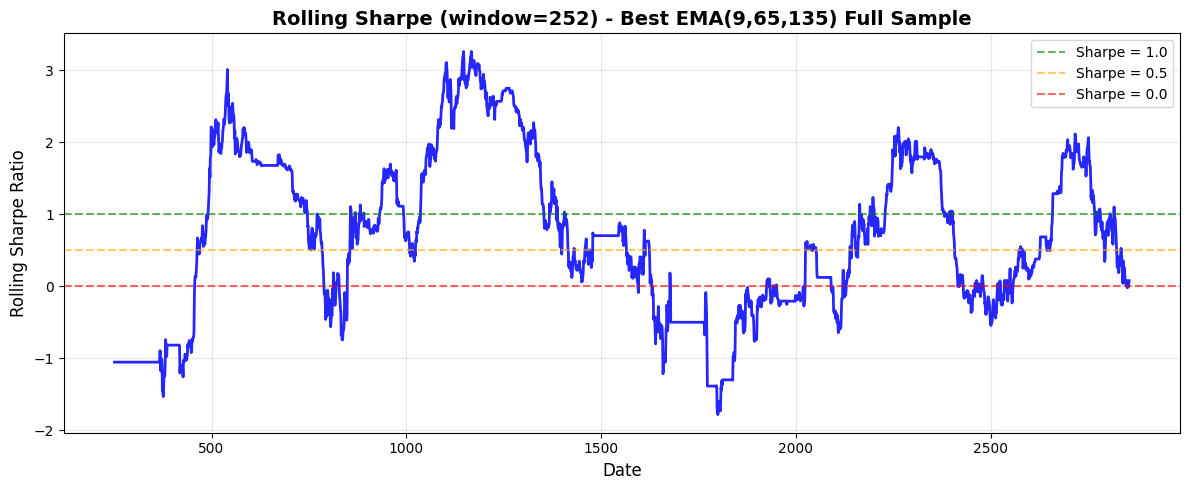

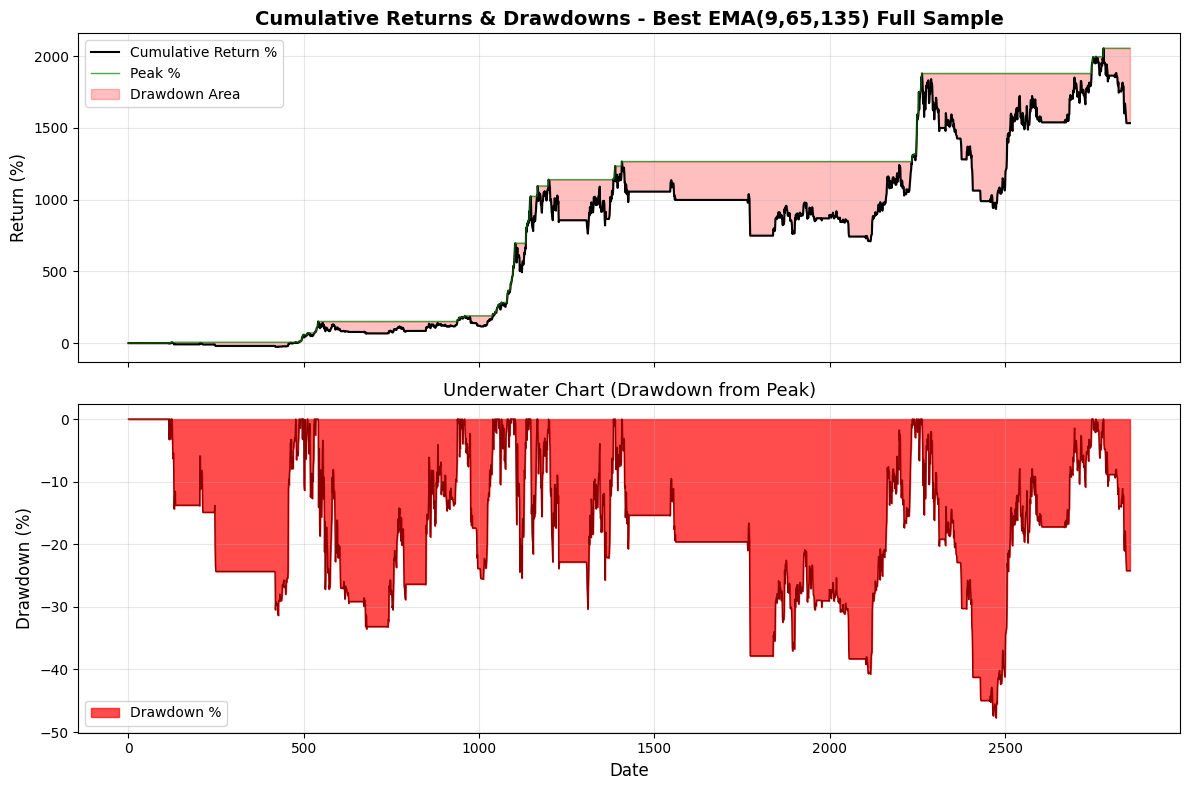

✅ Rolling Sharpe and Drawdown analysis complete for best strategy: EMA(9,65,135)


In [ ]:
# FULL-SAMPLE ROLLING SHARPE + DRAWDOWNS - BEST STRATEGY

if results_df.empty:
    print("No results to visualize.")
else:
    # Get BEST strategy (highest Sharpe ratio)
    best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    # Build full-sample Triple EMA signals
    ema1_full = vbt.MA.run(close, ema1, ewm=True).ma
    ema2_full = vbt.MA.run(close, ema2, ewm=True).ma
    ema3_full = vbt.MA.run(close, ema3, ewm=True).ma
    
    # Triple EMA crossover signals (RAW)
    entries_1 = ema1_full.vbt.crossed_above(ema2_full).reindex(close.index).fillna(False)
    entries_2 = ema1_full.vbt.crossed_above(ema3_full).reindex(close.index).fillna(False)
    entries_3 = ema2_full.vbt.crossed_above(ema3_full).reindex(close.index).fillna(False)
    entries_raw = entries_1 | entries_2 | entries_3
    
    exits_1 = ema1_full.vbt.crossed_below(ema2_full).reindex(close.index).fillna(False)
    exits_2 = ema1_full.vbt.crossed_below(ema3_full).reindex(close.index).fillna(False)
    exits_3 = ema2_full.vbt.crossed_below(ema3_full).reindex(close.index).fillna(False)
    exits_raw = exits_1 | exits_2 | exits_3
    
    # ⚠️ FIX LOOKAHEAD BIAS: Shift signals by 1 bar
    entries_full = entries_raw.shift(1).fillna(False).to_numpy(dtype=bool)
    exits_full = exits_raw.shift(1).fillna(False).to_numpy(dtype=bool)

    price_full = close.to_numpy(dtype=float)

    pf_full = vbt.Portfolio.from_signals(
        close=price_full,
        entries=entries_full,
        exits=exits_full,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    # Compute returns
    ret = pf_full.returns()

    # 1) Rolling Sharpe (252-day window)
    rolling_window = max(20, min(252, max(1, len(ret) // 4)))
    if len(ret) > rolling_window:
        rolling_sharpe = ret.rolling(window=rolling_window).apply(
            lambda x: (x.mean() * 252) / (x.std() * np.sqrt(252)) if x.std() and x.std() != 0 else np.nan,
            raw=False
        )

        plt.figure(figsize=(12, 5))
        plt.plot(rolling_sharpe.index, rolling_sharpe.values, linewidth=2, color='blue', alpha=0.85)
        plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.6, label='Sharpe = 1.0')
        plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.6, label='Sharpe = 0.5')
        plt.axhline(y=0.0, color='red', linestyle='--', alpha=0.6, label='Sharpe = 0.0')
        plt.title(f'Rolling Sharpe (window={rolling_window}) - Best EMA({ema1},{ema2},{ema3}) Full Sample', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Rolling Sharpe Ratio', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Not enough data for rolling Sharpe calculation.")

    # 2) Drawdowns (underwater)
    eq = (1 + ret).cumprod()
    peak = eq.cummax()
    dd = (eq - peak) / peak

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    ax1.plot(eq.index, (eq - 1) * 100, color='black', linewidth=1.5, label='Cumulative Return %')
    ax1.plot(peak.index, (peak - 1) * 100, color='green', linewidth=1.0, alpha=0.7, label='Peak %')
    ax1.fill_between(eq.index, (eq - 1) * 100, (peak - 1) * 100, color='red', alpha=0.25, label='Drawdown Area')
    ax1.set_title(f'Cumulative Returns & Drawdowns - Best EMA({ema1},{ema2},{ema3}) Full Sample', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Return (%)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.fill_between(dd.index, dd * 100, 0, color='red', alpha=0.7, label='Drawdown %')
    ax2.plot(dd.index, dd * 100, color='darkred', linewidth=1)
    ax2.set_title('Underwater Chart (Drawdown from Peak)', fontsize=13)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()
    
    print(f"✅ Rolling Sharpe and Drawdown analysis complete for best strategy: EMA({ema1},{ema2},{ema3})")

/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_88279/409243117.py:22: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_88279/409243117.py:23: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



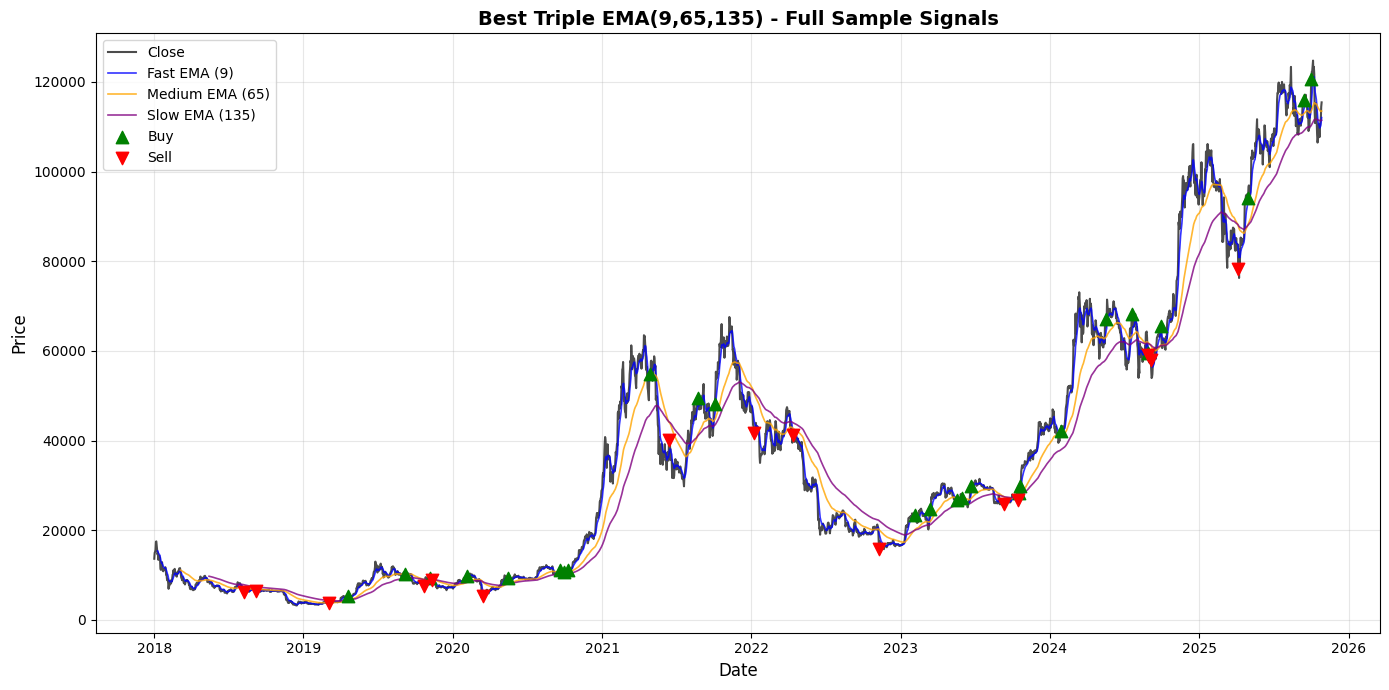

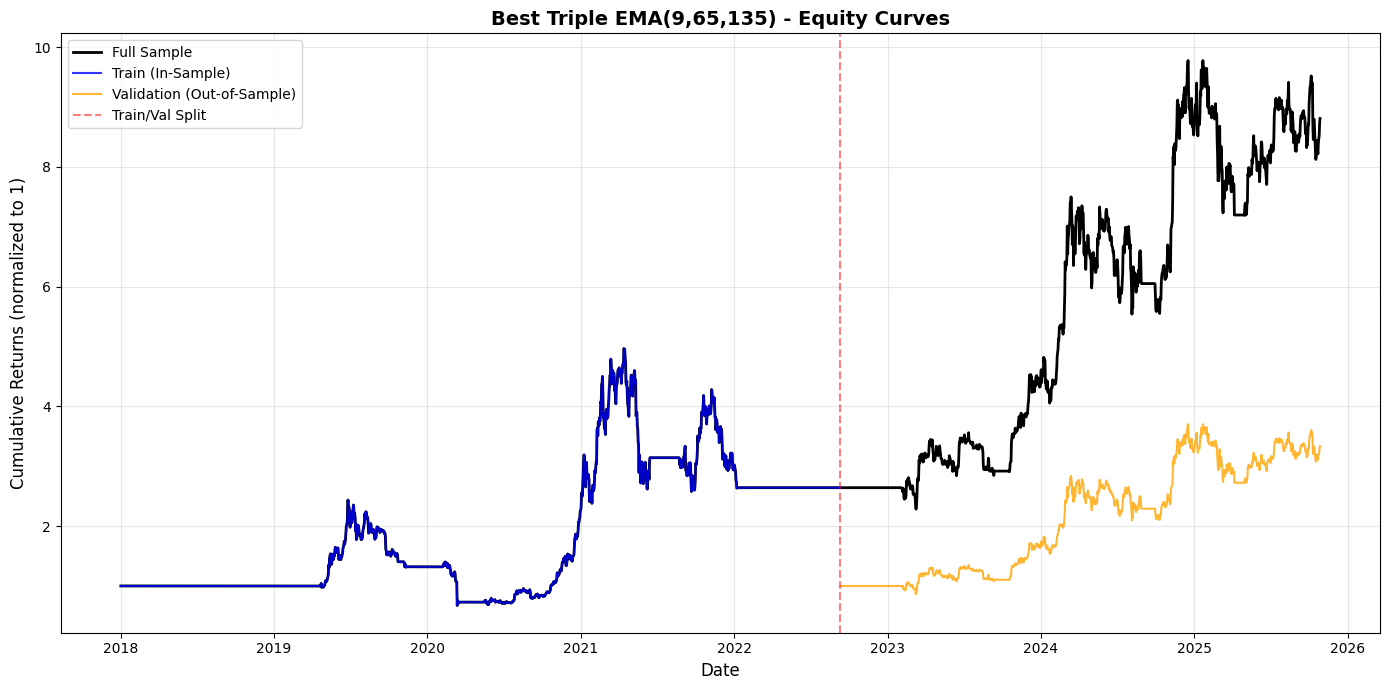

Visualizations complete for best strategy: EMA(9,65,135)


In [ ]:
# STEP 5C: VISUALS ONLY (Signals + Equity Curves) - BEST STRATEGY

if results_df.empty:
    print("No results to visualize.")
else:
    # Get BEST strategy (highest Sharpe ratio)
    best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    # Build full sample EMAs and signals for Triple EMA
    ema1_full = vbt.MA.run(close, ema1, ewm=True).ma
    ema2_full = vbt.MA.run(close, ema2, ewm=True).ma
    ema3_full = vbt.MA.run(close, ema3, ewm=True).ma
    
    # Triple EMA crossover signals (RAW)
    entries_raw = ((ema1_full.vbt.crossed_above(ema2_full) & (ema1_full > ema3_full)) |
                   (ema2_full.vbt.crossed_above(ema3_full) & (ema1_full > ema2_full)))
    exits_raw = ((ema1_full.vbt.crossed_below(ema2_full) & (ema1_full < ema3_full)) |
                 (ema2_full.vbt.crossed_below(ema3_full) & (ema1_full < ema2_full)))
    
    # ⚠️ FIX LOOKAHEAD BIAS: Shift signals by 1 bar
    entries_full = entries_raw.shift(1).fillna(False).reindex(close.index).fillna(False).to_numpy(dtype=bool)
    exits_full = exits_raw.shift(1).fillna(False).reindex(close.index).fillna(False).to_numpy(dtype=bool)

    # 1) Price + Triple EMAs + signals (full sample)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(close.index, close.values, label='Close', color='black', linewidth=1.5, alpha=0.7)
    ax.plot(close.index, ema1_full.values, label=f'Fast EMA ({ema1})', color='blue', alpha=0.8, linewidth=1.2)
    ax.plot(close.index, ema2_full.values, label=f'Medium EMA ({ema2})', color='orange', alpha=0.8, linewidth=1.2)
    ax.plot(close.index, ema3_full.values, label=f'Slow EMA ({ema3})', color='purple', alpha=0.8, linewidth=1.2)

    buy_idx = close.index[entries_full]
    sell_idx = close.index[exits_full]
    ax.scatter(buy_idx, close.reindex(buy_idx).values, marker='^', color='green', s=80, label='Buy', zorder=5)
    ax.scatter(sell_idx, close.reindex(sell_idx).values, marker='v', color='red', s=80, label='Sell', zorder=5)

    ax.set_title(f'Best Triple EMA({ema1},{ema2},{ema3}) - Full Sample Signals', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # 2) Equity curves: train / val / full
    price_full = close.to_numpy(dtype=float)
    entries_train = entries_full[:split_idx]
    exits_train = exits_full[:split_idx]
    entries_val = entries_full[split_idx:]
    exits_val = exits_full[split_idx:]

    pf_full = vbt.Portfolio.from_signals(
        close=price_full,
        entries=entries_full,
        exits=exits_full,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    pf_train = vbt.Portfolio.from_signals(
        close=train_close.to_numpy(dtype=float),
        entries=entries_train,
        exits=exits_train,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    pf_val2 = vbt.Portfolio.from_signals(
        close=val_close.to_numpy(dtype=float),
        entries=entries_val,
        exits=exits_val,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    eq_full = (1 + pf_full.returns()).cumprod()
    eq_train = (1 + pf_train.returns()).cumprod()
    eq_val = (1 + pf_val2.returns()).cumprod()

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(close.index, eq_full.values, label='Full Sample', color='black', linewidth=2)
    ax.plot(train_close.index, eq_train.values, label='Train (In-Sample)', color='blue', linewidth=1.5, alpha=0.8)
    ax.plot(val_close.index, eq_val.values, label='Validation (Out-of-Sample)', color='orange', linewidth=1.5, alpha=0.8)
    
    # Add vertical line to show train/val split
    ax.axvline(x=train_close.index[-1], color='red', linestyle='--', alpha=0.5, label='Train/Val Split')

    ax.set_title(f'Best Triple EMA({ema1},{ema2},{ema3}) - Equity Curves', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Returns (normalized to 1)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    print(f"Visualizations complete for best strategy: EMA({ema1},{ema2},{ema3})")

Total trades plotted: 33
Win Rate: 39.4% (13W / 20L)
Avg Win: 58.16% | Avg Loss: -7.65%
Max Win: 387.46% | Max Loss: -22.68%


/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_88279/383210688.py:53: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_88279/383210688.py:54: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



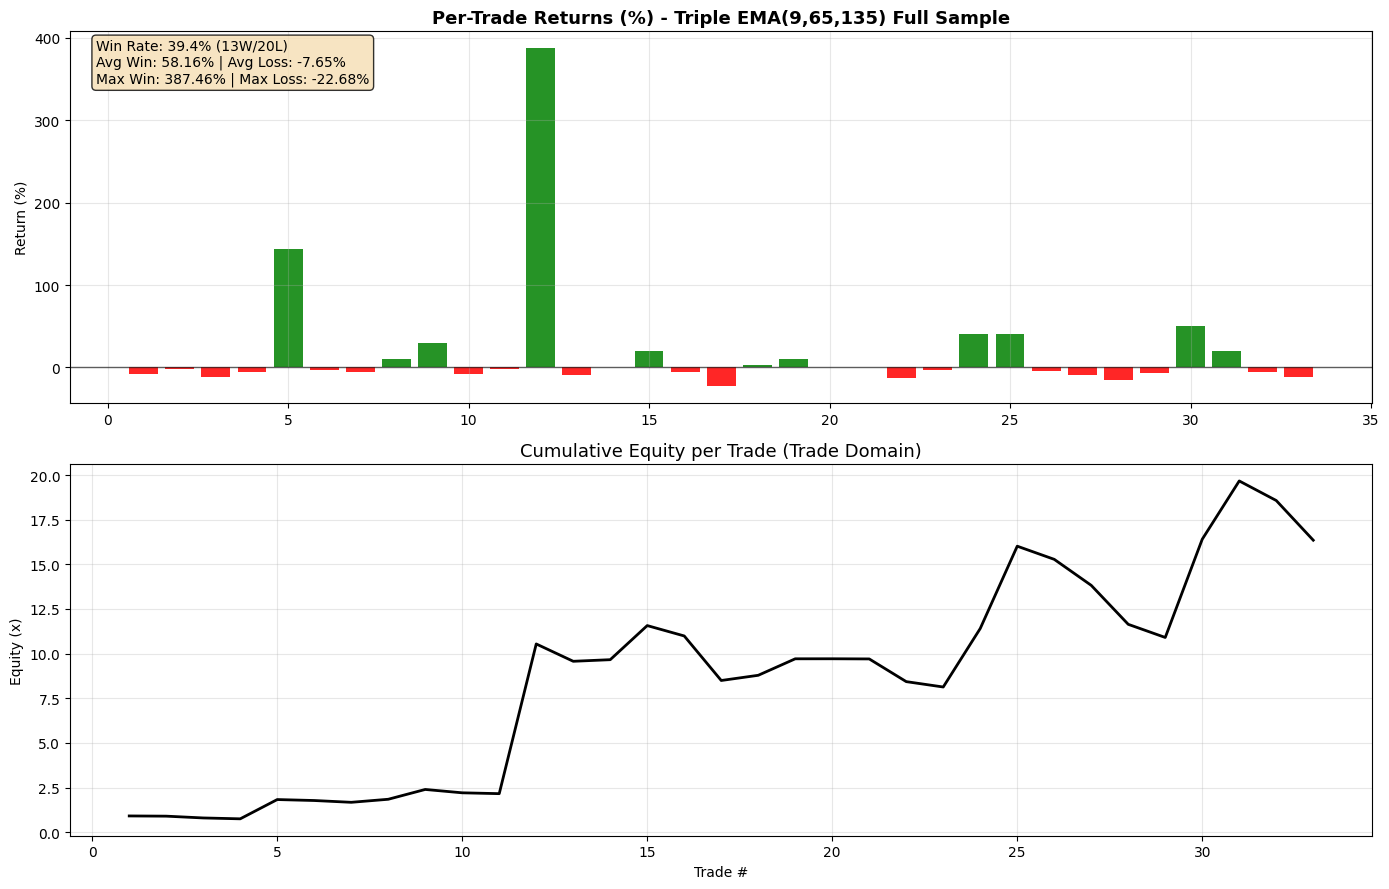

In [ ]:
# FULL-SAMPLE TRADE-BY-TRADE RETURNS (BAR) + CUMULATIVE PER-TRADE EQUITY — ALL TRADESbt

if 'FREQ' not in globals():
    FREQ = "1D"

# Resolve full close series
if 'close' in globals() and hasattr(close, 'index'):
    full_close = close.astype(float)
else:
    if isinstance(stock_data.columns, pd.MultiIndex):
        if ('Close', TICKER) in stock_data.columns:
            full_close = stock_data[('Close', TICKER)].astype(float).rename(TICKER)
        else:
            found = None
            for col in stock_data.columns:
                if isinstance(col, tuple) and ('Close' in col):
                    found = col; break
            if found is None:
                for col in stock_data.columns:
                    if 'Close' in str(col):
                        found = col; break
            if found is None:
                raise KeyError("Could not find a 'Close' column for full-sample trade plot.")
            full_close = stock_data[found].astype(float).rename(TICKER)
    else:
        full_close = stock_data['Close'].astype(float).rename(TICKER)

# Best params
if 'results_df' not in globals() or results_df.empty:
    raise ValueError("results_df is empty or missing. Run the grid search first.")
best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

# Indicators
ema1_full = vbt.MA.run(full_close, ema1, ewm=True)
ema2_full = vbt.MA.run(full_close, ema2, ewm=True)
ema3_full = vbt.MA.run(full_close, ema3, ewm=True)

# Signals (MATCH GRID SEARCH LOGIC - simple OR, no extra conditions)
entries_raw = (
    ema1_full.ma_crossed_above(ema2_full.ma) |
    ema1_full.ma_crossed_above(ema3_full.ma) |
    ema2_full.ma_crossed_above(ema3_full.ma)
)
exits_raw = (
    ema1_full.ma_crossed_below(ema2_full.ma) |
    ema1_full.ma_crossed_below(ema3_full.ma) |
    ema2_full.ma_crossed_below(ema3_full.ma)
)

# ⚠️ FIX LOOKAHEAD BIAS: Shift signals by 1 bar
# Convert to plain arrays AND shift
entries_shifted = pd.Series(np.asarray(entries_raw).ravel(), index=full_close.index, dtype=bool).shift(1).fillna(False)
exits_shifted = pd.Series(np.asarray(exits_raw).ravel(), index=full_close.index, dtype=bool).shift(1).fillna(False)

entries_full = pd.Series(np.asarray(entries_shifted).ravel(), index=full_close.index, dtype=bool)
exits_full = pd.Series(np.asarray(exits_shifted).ravel(), index=full_close.index, dtype=bool)

# Backtest
pf_full = vbt.Portfolio.from_signals(
    close=full_close.to_numpy(dtype=float),
    entries=entries_full,
    exits=exits_full,
    init_cash=100_000,
    fees=0.0005,
    slippage=0.0005,
    freq=FREQ
)

# Trade-by-trade returns (ALL trades)
trades = pf_full.trades
trade_returns = trades.returns.values if hasattr(trades.returns, 'values') else np.asarray(trades.returns)
trade_returns = np.asarray(trade_returns).ravel()  # ensure 1D

if trade_returns.size == 0:
    print("No trades to plot.")
else:
    # Calculate statistics
    winning_trades = trade_returns[trade_returns > 0]
    losing_trades = trade_returns[trade_returns < 0]
    
    total_trades = len(trade_returns)
    win_count = len(winning_trades)
    loss_count = len(losing_trades)
    win_rate = (win_count / total_trades * 100) if total_trades > 0 else 0
    
    avg_win_pct = (winning_trades.mean() * 100) if len(winning_trades) > 0 else 0
    avg_loss_pct = (losing_trades.mean() * 100) if len(losing_trades) > 0 else 0
    max_win_pct = (winning_trades.max() * 100) if len(winning_trades) > 0 else 0
    max_loss_pct = (losing_trades.min() * 100) if len(losing_trades) > 0 else 0
    
    print(f"Total trades plotted: {total_trades}")
    print(f"Win Rate: {win_rate:.1f}% ({win_count}W / {loss_count}L)")
    print(f"Avg Win: {avg_win_pct:.2f}% | Avg Loss: {avg_loss_pct:.2f}%")
    print(f"Max Win: {max_win_pct:.2f}% | Max Loss: {max_loss_pct:.2f}%")
    
    equity_per_trade = np.cumprod(1.0 + trade_returns)

    fig, axes = plt.subplots(2, 1, figsize=(14, 9), sharex=False)

    # Per-trade returns (%), all trades
    x = np.arange(1, trade_returns.size + 1)
    colors = np.where(trade_returns >= 0, 'green', 'red')
    axes[0].bar(x, trade_returns * 100.0, color=colors, alpha=0.85, width=0.8)
    axes[0].axhline(0, color='black', linewidth=1, alpha=0.6)
    
    # Add statistics text box on the chart
    stats_text = (
        f'Win Rate: {win_rate:.1f}% ({win_count}W/{loss_count}L)\n'
        f'Avg Win: {avg_win_pct:.2f}% | Avg Loss: {avg_loss_pct:.2f}%\n'
        f'Max Win: {max_win_pct:.2f}% | Max Loss: {max_loss_pct:.2f}%'
    )
    axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    axes[0].set_title(f'Per-Trade Returns (%) - Triple EMA({ema1},{ema2},{ema3}) Full Sample', 
                     fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Return (%)')
    axes[0].grid(True, alpha=0.3)

    # Cumulative equity per trade
    axes[1].plot(x, equity_per_trade, color='black', linewidth=2)
    axes[1].set_title('Cumulative Equity per Trade (Trade Domain)', fontsize=13)
    axes[1].set_xlabel('Trade #')
    axes[1].set_ylabel('Equity (x)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [ ]:
#PARAMETER SENSITIVITY TABLE

if results_df.empty:
    print("No results available for sensitivity analysis.")
else:
    # Get BEST strategy (highest Sharpe ratio)
    best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    print(f"Parameter Sensitivity Analysis for Best EMA({ema1},{ema2},{ema3})")
    print("=" * 80)

    # Create sensitivity ranges (±15 around each parameter)
    fast_candidates = list(range(max(2, ema1 - 15), ema1 + 16))
    medium_candidates = list(range(max(3, ema2 - 15), ema2 + 16))
    slow_candidates = list(range(max(4, ema3 - 15), ema3 + 16))
    
    # Test variations: vary one parameter at a time
    combos = ([(f, ema2, ema3) for f in fast_candidates] +
              [(ema1, m, ema3) for m in medium_candidates if m != ema2] +
              [(ema1, ema2, s) for s in slow_candidates if s != ema3])

    price_np = train_close.to_numpy(dtype=float)
    idx = train_close.index

    def series_to_np_bool(s: pd.Series) -> np.ndarray:
        return s.reindex(idx).where(s.reindex(idx).notna(), False).astype(bool).to_numpy(dtype=bool)

    def eval_combo(e1: int, e2: int, e3: int) -> dict:
        fma = vbt.MA.run(train_close, e1, ewm=True).ma
        mma = vbt.MA.run(train_close, e2, ewm=True).ma
        sma = vbt.MA.run(train_close, e3, ewm=True).ma
        
        # Triple EMA crossover (RAW)
        e_raw = (fma.vbt.crossed_above(mma) & (fma > sma)) | (mma.vbt.crossed_above(sma) & (fma > mma))
        x_raw = (fma.vbt.crossed_below(mma) & (fma < sma)) | (mma.vbt.crossed_below(sma) & (fma < mma))
        
        # ⚠️ FIX LOOKAHEAD BIAS: Shift signals by 1 bar (avoiding FutureWarning)
        e_shifted = e_raw.shift(1).where(e_raw.shift(1).notna(), False).astype(bool)
        x_shifted = x_raw.shift(1).where(x_raw.shift(1).notna(), False).astype(bool)
        
        e = series_to_np_bool(e_shifted)
        x = series_to_np_bool(x_shifted)

        pf = vbt.Portfolio.from_signals(
            close=price_np, entries=e, exits=x,
            init_cash=100_000, fees=0.0005, slippage=0.0005, freq=FREQ
        )

        total_return = float(pf.total_return())
        sharpe = float(pf.sharpe_ratio(freq=FREQ))
        sortino = float(pf.sortino_ratio(freq=FREQ))
        mdd = float(pf.max_drawdown())
        vol = float(pf.annualized_volatility(freq=FREQ))

        trades = pf.trades
        ntr = len(trades)
        win_rate_pct = np.nan
        profit_factor = np.nan
        expectancy = 0.0
        if ntr > 0:
            tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
            if tr.size > 0:
                pos = tr[tr > 0]
                neg = tr[tr < 0]
                win_rate_pct = (len(pos) / len(tr)) * 100 if len(tr) else np.nan
                gains = pos.sum() if len(pos) else 0.0
                losses = abs(neg.sum()) if len(neg) else 0.0
                profit_factor = gains / losses if losses > 0 else np.inf
                expectancy = float(tr.mean())

        return {
            'ema1': e1, 'ema2': e2, 'ema3': e3,
            'sharpe': sharpe, 'sortino': sortino,
            'total_return': total_return, 'max_drawdown': mdd, 'volatility': vol,
            'total_trades': ntr, 'win_rate_pct': win_rate_pct,
            'profit_factor': profit_factor, 'expectancy': expectancy
        }

    rows = []
    for combo in combos:
        try:
            rows.append(eval_combo(*combo))
        except Exception:
            pass

    if not rows:
        print("No sensitivity results computed.")
    else:
        sens = pd.DataFrame(rows)

        # Show as a table
        cols = ['ema1','ema2','ema3','sharpe','sortino','total_return','max_drawdown','volatility',
                'total_trades','win_rate_pct','profit_factor','expectancy']
        sens_table = sens[cols].sort_values(['ema1','ema2','ema3'])
        
        print(f"Sensitivity Results ({len(sens_table)} variations tested):\n")
        display(sens_table)

        # Compact variation summary
        metric_cols = ['sharpe','sortino','total_return','max_drawdown','volatility',
                       'win_rate_pct','profit_factor','expectancy']
        summary = sens_table[metric_cols].agg(['mean','std','min','max']).T
        
        print("Sensitivity Summary (mean / std / min / max):")
        print(summary.round(4).to_string())

Parameter Sensitivity Analysis for Best EMA(9,65,135)
Sensitivity Results (83 variations tested):



,ema1,ema2,ema3,sharpe,sortino,total_return,max_drawdown,volatility,total_trades,win_rate_pct,profit_factor,expectancy
0,2,65,135,0.673071,0.953134,1.671152,-0.720275,0.513895,5,40.000000,5.652449,0.610684
1,3,65,135,0.635624,0.896229,1.435241,-0.720209,0.510685,6,33.333333,4.972266,0.493940
2,4,65,135,0.676664,0.958352,1.694542,-0.717826,0.513965,5,40.000000,5.725074,0.612349
3,5,65,135,0.686584,0.972604,1.759510,-0.711022,0.513841,5,40.000000,5.936948,0.616974
4,6,65,135,0.675374,0.956357,1.686416,-0.718677,0.514093,5,40.000000,5.699633,0.611770
...,...,...,...,...,...,...,...,...,...,...,...,...
18,20,65,135,0.694511,0.984455,1.810897,-0.705641,0.513024,4,50.000000,6.115973,0.775790
19,21,65,135,0.694511,0.984455,1.810897,-0.705641,0.513024,4,50.000000,6.115973,0.775790
20,22,65,135,0.694511,0.984455,1.810897,-0.705641,0.513024,4,50.000000,6.115973,0.775790
21,23,65,135,0.694511,0.984455,1.810897,-0.705641,0.513024,4,50.000000,6.115973,0.775790


Sensitivity Summary (mean / std / min / max):
                  mean     std      min      max
sharpe          0.6810  0.0358   0.6006   0.8054
sortino         0.9656  0.0499   0.8525   1.1410
total_return    1.7319  0.2345   1.2542   2.6365
max_drawdown   -0.6966  0.0199  -0.7249  -0.6573
volatility      0.5145  0.0052   0.5065   0.5254
win_rate_pct   45.5823  5.1300  33.3333  50.0000
profit_factor   5.6851  0.6030   4.6648   8.0303
expectancy      0.6481  0.0764   0.4939   0.8202
